In [1]:
options(warn = -1)
pacotes <- c("tidyquant", "timetk","tidyverse", "PortfolioAnalytics",
             "corrplot")
for(i in pacotes){
  suppressPackageStartupMessages(library(i, character.only = T))
}

In [2]:
acoes <- c("BIDI4.SA","LREN3.SA",
           "ENBR3.SA","FLRY3.SA",
           "WEGE3.SA","ABEV3.SA",
           "GRND3.SA","ITSA4.SA",
           "RADL3.SA")
n_acoes <- c(5,10,12,9,5,20,22,26,5)
n_tot <- data.frame(symbol = acoes, n = n_acoes)
data_inicio <- "2013-01-01"
mudanca_recente <- "2013-01-01"

In [3]:
dividendos <- tq_get(acoes, "dividends", from = data_inicio)
precos <- tq_get(acoes, from = first(dividendos$date)) %>%
    select(date, symbol, adjusted) %>%
    left_join(n_tot, by = c("symbol" = "symbol")) %>%
    group_by(symbol, date) %>%
    summarise(adjusted = adjusted*n) %>%
    spread(key = symbol, value = adjusted) %>%
    na.omit %>%
    gather(key = "symbol", value = "adjusted", -c(date))

`summarise()` regrouping output by 'symbol' (override with `.groups` argument)



In [4]:
tot <- left_join(precos, dividendos, by = c("date"="date", "symbol"= "symbol"))
tot[,4] <- na.fill(tot[,4], 0)

In [5]:
dy <- tot %>%
  group_by(date) %>%
  summarise(dy = sum(value)/sum(adjusted)) %>%
  mutate(ano = year(date)) %>%
  group_by(ano) %>%
  summarise(dy = sum(dy))
dividendos_a <- tot %>%
  mutate(ano = year(date)) %>%
  group_by(ano, symbol) %>%
  na.omit() %>%
  summarise(Dividendos = sum(value), Preço = last(adjusted))
tot_g <- dividendos_a %>%
  gather(key = "data", value = "prices", -c(ano, symbol))

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'ano' (override with `.groups` argument)



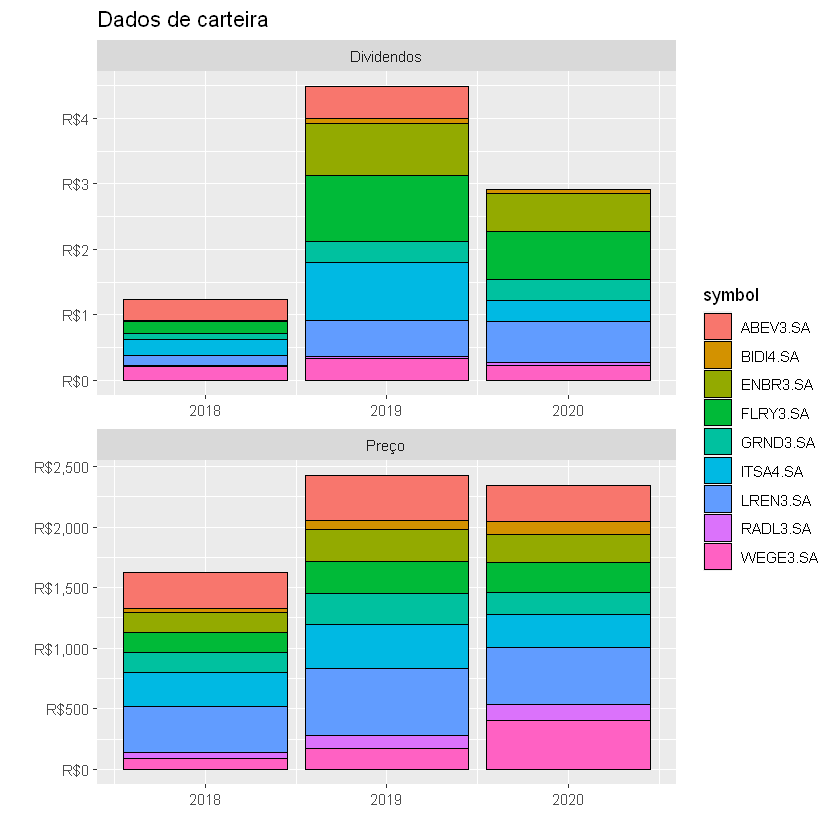

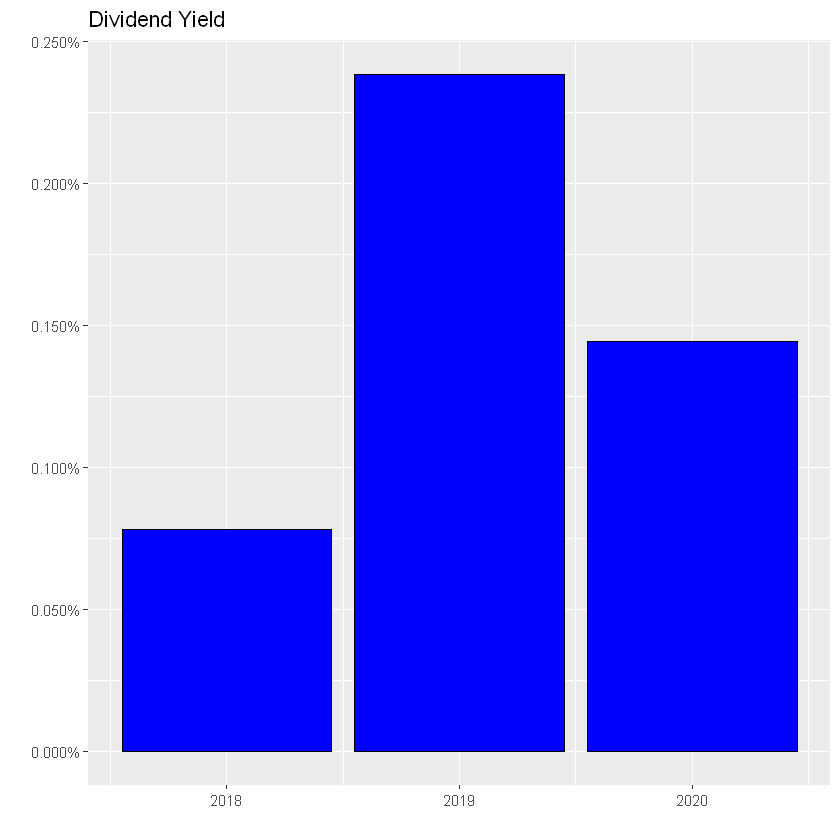

In [6]:
ggplot(tot_g, aes(x = ano, y = prices, fill = symbol))+
  geom_col(col = "black")+
  labs(x = "", y = "", title = "Dados de carteira")+
  scale_y_continuous(labels = scales::dollar_format(prefix = "R$"))+
  facet_wrap(~data, nrow = 3, scales = "free")
ggplot(dy, aes(x = ano, y = dy))+
  geom_col(fill = "blue", col = "black")+
  labs(x = "", y = "", title = "Dividend Yield")+
  scale_y_continuous(labels = scales::percent)

`summarise()` ungrouping output (override with `.groups` argument)



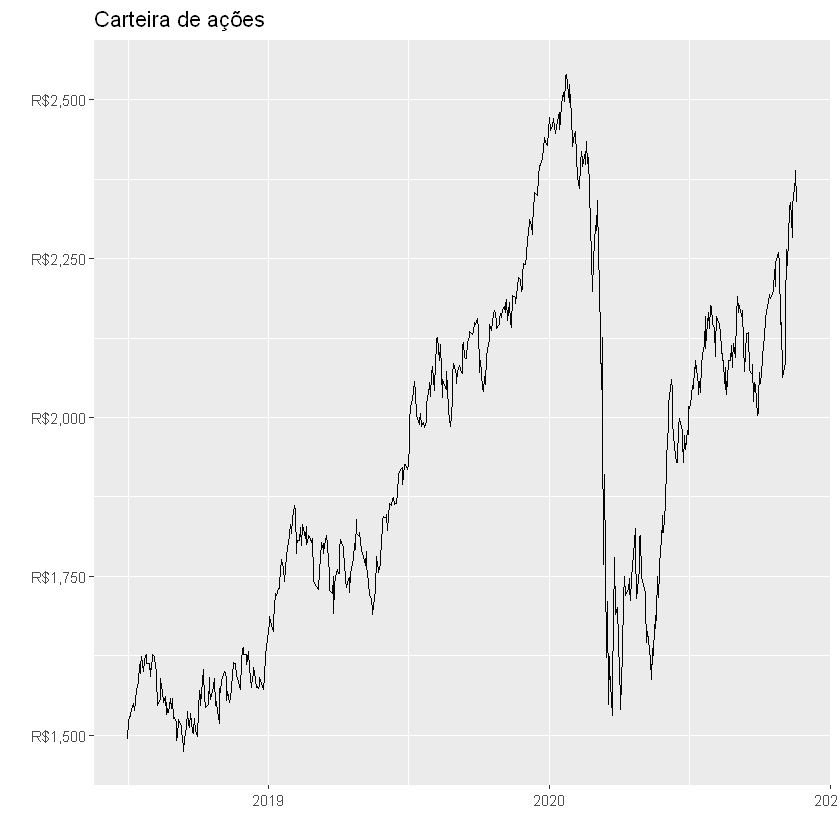

In [7]:
carteira <- tot %>%
  group_by(date) %>%
  summarise(carteira = sum(adjusted), dividendos = sum(value))
carteira$variacao <- c(0,diff(carteira$carteira)/carteira$carteira[2:nrow(carteira)-1])
carteira$drawdown <- carteira$carteira/cummax(carteira$carteira)-1
ggplot(carteira, aes(x = date, y = carteira))+
  geom_line()+
  labs(x = "", y = "", title = "Carteira de ações")+
  scale_y_continuous(labels = scales::dollar_format(prefix = "R$"))+
  geom_vline(xintercept = as.Date(mudanca_recente), lty = 2)

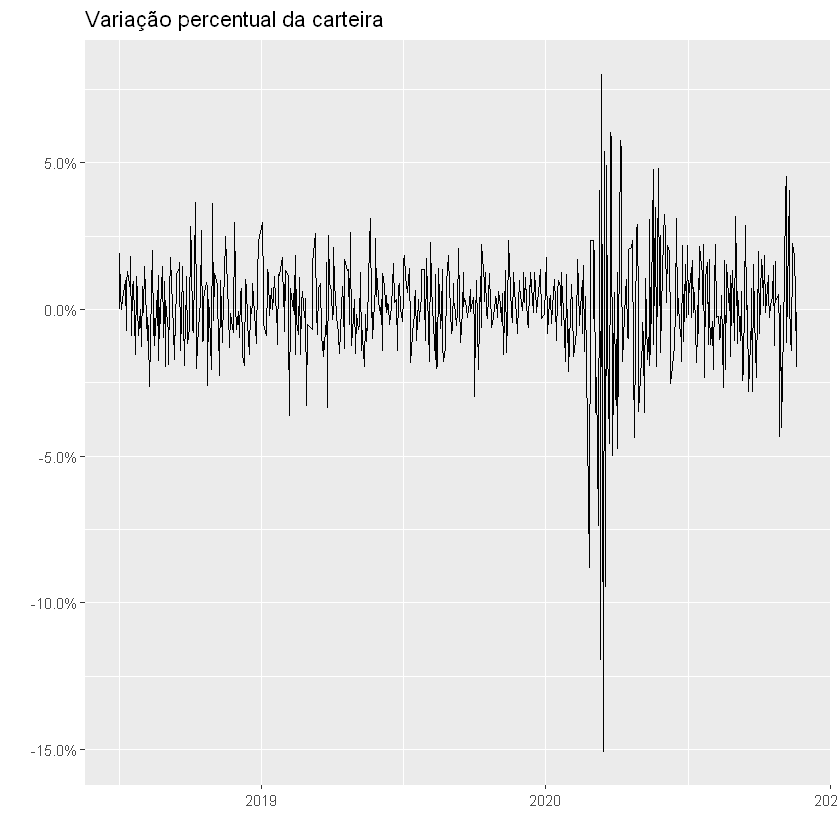

In [8]:
ggplot(carteira, aes(x = date, y = variacao))+
  geom_line()+
  labs(x = "", y = "", title = "Variação percentual da carteira")+
  scale_y_continuous(labels = scales::percent)

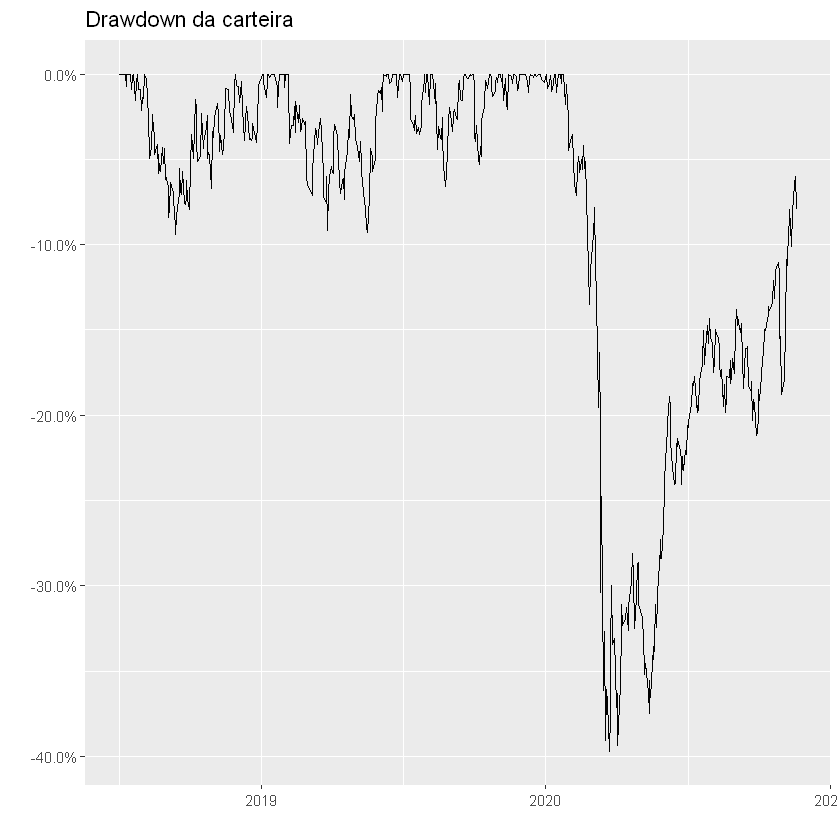

In [9]:
ggplot(carteira, aes(x = date, y = drawdown))+
  geom_line()+
  labs(x = "", y = "", title = "Drawdown da carteira")+
  scale_y_continuous(labels = scales::percent)

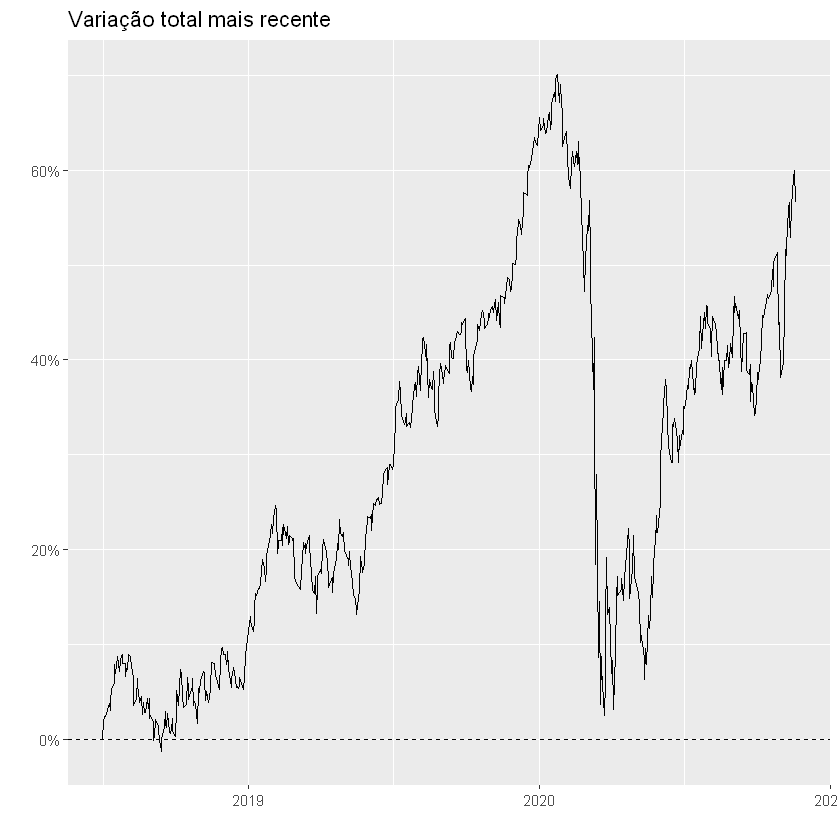

In [10]:
carteira_rec <- carteira %>%
  filter(date >= mudanca_recente) %>%
  summarise(date,carteira, variacao, dividendos)
carteira_rec$variacao_tot <- cumprod(c(0,carteira_rec$variacao[2:nrow(carteira_rec)])+1)-1
ggplot(carteira_rec, aes(x = date, y = variacao_tot))+
  geom_line()+
  labs(x = "", y = "", title = "Variação total mais recente")+
  scale_y_continuous(labels = scales::percent)+
  geom_hline(yintercept = 0, lty = 2)

In [11]:
xts::last(carteira_rec,10)

date,carteira,variacao,dividendos,variacao_tot
<date>,<dbl>,<dbl>,<dbl>,<dbl>
2020-11-06,2238.31,-0.011423492,0.023872,0.4989807
2020-11-09,2329.37,0.040682463,0.000000,0.5599630
2020-11-10,2338.12,0.003756381,0.000000,0.5658228
2020-11-11,2315.26,-0.009777074,0.000000,0.5505136
2020-11-12,2282.84,-0.014002737,0.000000,0.5288022
2020-11-13,2334.20,0.022498272,0.000000,0.5631976
2020-11-16,2376.68,0.018198956,0.000000,0.5916462
2020-11-17,2387.98,0.004754526,0.000000,0.5992137
2020-11-18,2341.61,-0.019418082,0.000000,0.5681600


In [13]:
precos %>%
  filter(date == last(date)) %>%
  summarise(symbol,adjusted = adjusted/sum(adjusted))

symbol,adjusted
<chr>,<dbl>
ABEV3.SA,0.12595342
BIDI4.SA,0.04690119
ENBR3.SA,0.09624791
FLRY3.SA,0.10516212
GRND3.SA,0.07759859
ITSA4.SA,0.11916407
LREN3.SA,0.20068748
RADL3.SA,0.05528098
WEGE3.SA,0.17300424


In [79]:
#Coletando os dados
s <- tq_get(acoes, from = data_inicio)

In [87]:
#Mudando os dados
month_retun <- s %>%
  group_by(symbol) %>%
  tq_transmute(select = close, mutate_fun = periodReturn, period = "monthly")
daily_retunr <- s %>%
  group_by(symbol) %>%
  tq_transmute(select = close, mutate_fun = periodReturn, period = "daily")
retornos_m <- month_retun %>%
  mutate(year = year(date)) %>%
  group_by(symbol, year) %>%
  summarise(Retorno_Mensal_Médio = mean(monthly.returns),
            Desvio_Mensal = sd(monthly.returns)) %>%
  gather(Retorno_Mensal_Médio, Desvio_Mensal, key = statistic, value = value)
retornos <- daily_retunr %>%
  mutate(year = year(date)) %>%
  group_by(symbol, year) %>%
  summarise(Retorno_Diário = mean(daily.returns),
            Desvio_Padrão = sd(daily.returns)) %>%
  gather(Retorno_Diário, Desvio_Padrão, key = statistic, value = value)

`summarise()` regrouping output by 'symbol' (override with `.groups` argument)

`summarise()` regrouping output by 'symbol' (override with `.groups` argument)



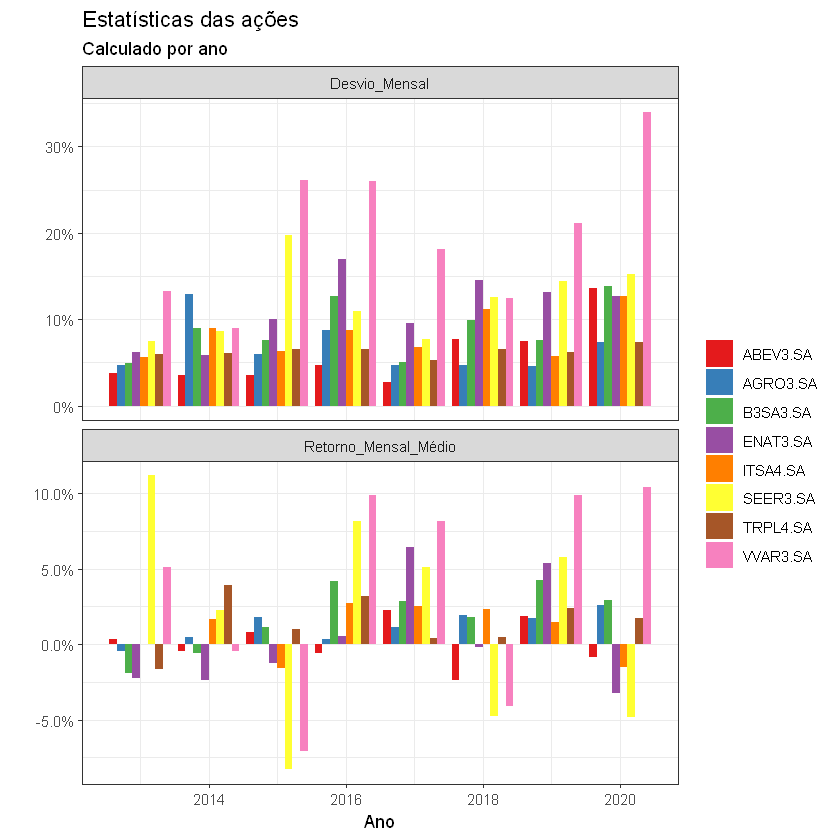

In [88]:
#Gráficos
retornos_m %>%
  ggplot(aes(year,value))+
  geom_col(aes(fill = symbol), position = "dodge")+
  scale_y_continuous(labels = scales::percent)+
  theme_bw()+
  scale_fill_brewer(palette = "Set1",
                    name = "")+
  facet_wrap(~statistic, scales = "free_y", nrow = 2)+
  labs(x = "Ano", y = "", title = "Estatísticas das ações",
      subtitle = "Calculado por ano")

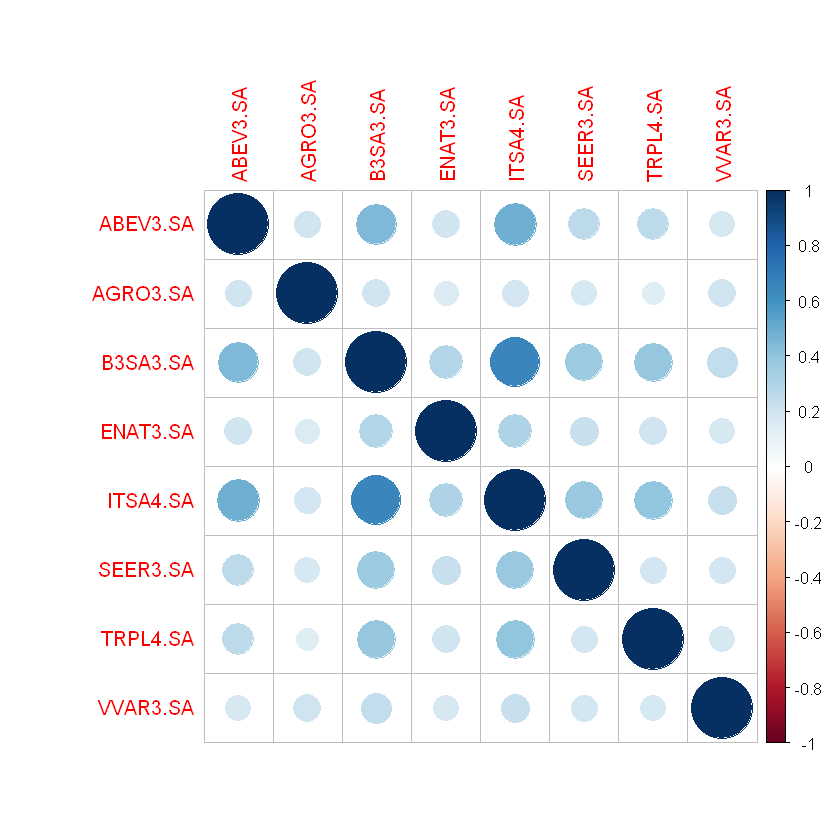

In [89]:
correlacao <- daily_retunr %>%
  spread(key = symbol, value = daily.returns) %>%
  na.omit()
correlacao <- cor(correlacao[,-1])
corrplot(correlacao)

In [83]:
correlacao

,ABEV3.SA,AGRO3.SA,B3SA3.SA,ENAT3.SA,ITSA4.SA,SEER3.SA,TRPL4.SA,VVAR3.SA
ABEV3.SA,1.0000000,0.1930296,0.4441371,0.1958562,0.4815958,0.2687821,0.2616784,0.1770794
AGRO3.SA,0.1930296,1.0000000,0.1997454,0.1595116,0.1887909,0.1758927,0.1372271,0.2004003
B3SA3.SA,0.4441371,0.1997454,1.0000000,0.2955938,0.6508046,0.3663455,0.3872554,0.2479104
ENAT3.SA,0.1958562,0.1595116,0.2955938,1.0000000,0.3050678,0.2208600,0.1995221,0.1774810
ITSA4.SA,0.4815958,0.1887909,0.6508046,0.3050678,1.0000000,0.3721461,0.3979168,0.2215496
SEER3.SA,0.2687821,0.1758927,0.3663455,0.2208600,0.3721461,1.0000000,0.1868974,0.1887436
TRPL4.SA,0.2616784,0.1372271,0.3872554,0.1995221,0.3979168,0.1868974,1.0000000,0.1704358
VVAR3.SA,0.1770794,0.2004003,0.2479104,0.1774810,0.2215496,0.1887436,0.1704358,1.0000000
